In [ ]:
#Various importings I will need during the running
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.feature_selection import SequentialFeatureSelector,SelectKBest,f_classif
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor, BaggingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report ,mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import torch

import warnings
warnings.filterwarnings('ignore')

1. LOAD THE DATASET AND DATA PREPROCESSING

In [ ]:
#to run the project, need to upload the kaggle.json file from the repository
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lorenzoaveroldi","key":"0ff8b4658b68ab3247fade234b7a5364"}'}

In [ ]:
import os,zipfile
os.makedirs("/root/.kaggle", exist_ok=True)
os.rename("kaggle.json", "/root/.kaggle/kaggle.json")

os.chmod("/root/.kaggle/kaggle.json", 600)


In [ ]:
!kaggle datasets download -d redwankarimsony/heart-disease-data
with zipfile.ZipFile("heart-disease-data.zip", "r") as zip_ref:
    zip_ref.extractall("heart-disease-data")

Dataset URL: https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data
License(s): copyright-authors
  0% 0.00/12.4k [00:00<?, ?B/s]
100% 12.4k/12.4k [00:00<00:00, 43.8MB/s]


In [ ]:
#Visualize the dataset
df = pd.read_csv("/content/heart-disease-data/heart_disease_uci.csv")
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [ ]:
#Dropping columns id and dataset, this columns don't represent a useful feature for us
df=df.drop(columns=["id","dataset"], axis=1)


Preliminary visualization, to see how target and classes are unbalanced

num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64


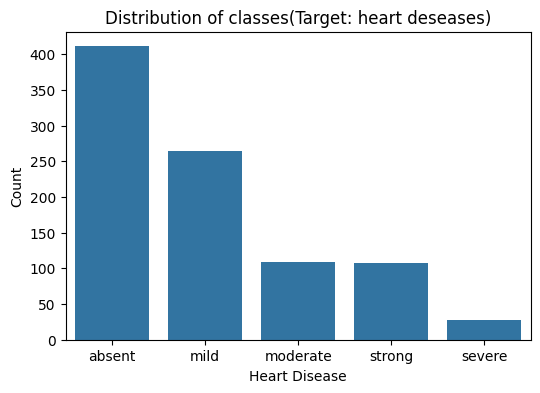

In [ ]:
target_balance=df['num'].value_counts()
print(target_balance)

#distribution of classes, very unbalanced for multiclass clasisfication
plt.figure(figsize=(6,4))
sns.countplot(data=df,x='num')
plt.xticks([0,1,2,3,4],['absent','mild','moderate','strong','severe'])
plt.xlabel('Heart Disease')
plt.ylabel('Count')
plt.title('Distribution of classes(Target: heart deseases)')
plt.show()

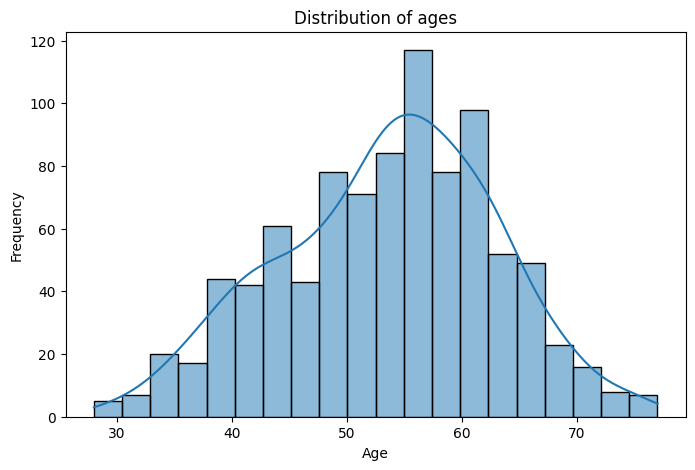

In [ ]:
#Distribution of ages
plt.figure(figsize=(8,5))
sns.histplot(df['age'], kde=True, bins=20)
plt.title('Distribution of ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


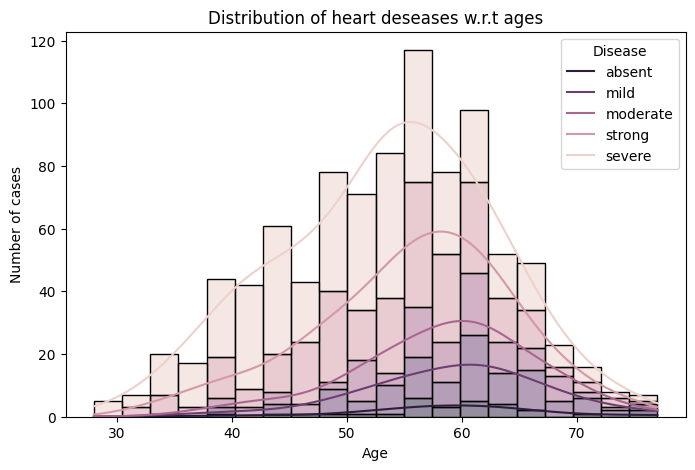

In [ ]:
#Distribution of heart deseases w.r.t ages
plt.figure(figsize=(8,5))
sns.histplot(data=df, x='age', hue='num', bins=20, kde=True, multiple='stack')
plt.title('Distribution of heart deseases w.r.t ages')
plt.xlabel('Age')
plt.ylabel('Number of cases')
plt.legend(title='Disease', labels=['absent', 'mild','moderate','strong','severe'])
plt.show()


2. Fill empty values and one-hot encode

In [ ]:
numerical_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
n_components=15
# Correctly impute missing values in numerical columns
imputer_numerical = SimpleImputer(strategy="mean")
df[numerical_features] = imputer_numerical.fit_transform(df[numerical_features])

# Correctly impute missing values in categorical columns with the most frequent value
imputer_categorical = SimpleImputer(strategy="most_frequent")
df[categorical_features] = imputer_categorical.fit_transform(df[categorical_features])


# One-hot encode categorical columns
df = pd.get_dummies(df, columns=['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'], drop_first=True)


#check if any missing value is still present
(df.isnull().sum()).sort_values(ascending=False)

,0
age,0
trestbps,0
chol,0
thalch,0
oldpeak,0
num,0
sex_Male,0
cp_atypical angina,0
cp_non-anginal,0
cp_typical angina,0


In [ ]:
#Prepare the datasets, for binary and multiclass classification
X=df.drop(columns=['num'], axis=1)
y_5_classes = df['num']
#To simplify, we are gonna do a binary classification as main task
df['num'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
y=df['num']



#Split the dataset in train e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=24)
X_Tr_5, X_Te_5, y_Tr_5, y_Te_5 = train_test_split(X, y_5_classes, test_size=0.25, random_state=24)

MODEL #1: K-NN

We are gonna to try the K-NN model with different hyperparameters and choosing the best one



In [ ]:
#Split the training set in training e validation, we need the validation set only for K-NN to decide which k is the best one
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=32)
X_Tr_5, X_Val_5, y_Tr_5, y_Val_5 = train_test_split(X_Tr_5, y_Tr_5, test_size=0.25, random_state=32)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features) # Scale numerical features
    ],
    remainder='passthrough' # Keep the one-hot encoded categorical columns
)


k_values = [3, 5, 7, 9, 15, 22, 35]

def run_knn(X_train, y_train, X_val, y_val, X_test, y_test, k_values, F_selection, B_class, Run_PCA):
  best_k = None
  best_accuracy = 0

  pca='No'
  f_sel='No'
  for k in k_values:
    if(F_selection):
      f_sel='Yes'
      sfs = SequentialFeatureSelector(KNeighborsClassifier(n_neighbors=k), n_features_to_select=10)
      sfs.fit(X_train, y_train)
      selected_features = X.columns[sfs.get_support()]
      X_train_selected = X_train[selected_features]
      X_val_selected = X_val[selected_features]
      X_test_selected = X_test[selected_features]
      numerical_selected=[f for f in numerical_features if f in selected_features]

      preprocessor_selected = ColumnTransformer(
      transformers=[
          ('num', StandardScaler(), numerical_selected) # Scale numerical features
      ],
      remainder='passthrough' # Keep the one-hot encoded categorical columns
      )

    if(F_selection):
      pipeline = Pipeline(steps=[('preprocessor', preprocessor_selected),
                                ('classifier', KNeighborsClassifier(n_neighbors=k))])
      pipeline.fit(X_train_selected, y_train)
      accuracy = pipeline.score(X_val_selected, y_val)
    elif(Run_PCA):
            pca='Yes'
            pipeline=Pipeline(steps=[('preprocessor', preprocessor),
                                     ('pca', PCA(n_components=n_components, svd_solver='full')),
                                    ('classifier', KNeighborsClassifier(n_neighbors=k))])
            pipeline.fit(X_train, y_train)
            accuracy = pipeline.score(X_val, y_val)

    else:
      pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', KNeighborsClassifier(n_neighbors=k))])
      pipeline.fit(X_train, y_train)
      accuracy = pipeline.score(X_val, y_val)




    if accuracy > best_accuracy:
        best_k = k
        best_accuracy = accuracy
  #then create the final pipeline
  if(F_selection):
    final_pipeline = Pipeline(steps=[('preprocessor', preprocessor_selected),
                                ('classifier', KNeighborsClassifier(n_neighbors=best_k))])
    final_pipeline.fit(X_train_selected, y_train)

    test_acc = final_pipeline.score(X_test_selected, y_test)
    y_pred=final_pipeline.predict(X_test_selected)
  elif (Run_PCA):
            final_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('pca', PCA(n_components=n_components, svd_solver='full')),
                                ('classifier', KNeighborsClassifier(n_neighbors=best_k))])
            final_pipeline.fit(X_train, y_train)
            test_acc = final_pipeline.score(X_test, y_test)
            y_pred=final_pipeline.predict(X_test)
  else:
    final_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', KNeighborsClassifier(n_neighbors=best_k))])
    final_pipeline.fit(X_train, y_train)

    test_acc = final_pipeline.score(X_test, y_test)
    y_pred=final_pipeline.predict(X_test)

  #test the model and append results
  if(B_class):
    p_score=precision_score(y_test, y_pred)
    rc_score=recall_score(y_test, y_pred)
    f1_sc=f1_score(y_test, y_pred)
    print("Confusion Matrix")
    plt.figure()
    ConfusionMatrixDisplay.from_estimator(final_pipeline, X_test, y_test)
    plt.title(f"Confusion Matrix - KNN")
    plt.grid(False)
    plt.show()
    results.append({'Model': 'KNN',
        'PCA': pca,
        'F_Sel':f_sel,
        'Classes': 'Binary',
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': p_score,
        'Recall': rc_score,
        'F1-score': f1_sc})
  else:
    p_score=precision_score(y_test, y_pred, average='weighted')
    rc_score=recall_score(y_test, y_pred, average='weighted')
    f1_sc=f1_score(y_test, y_pred, average='weighted')

    results.append({'Model': 'KNN',
        'PCA': pca,
        'F_Sel':f_sel,
        'Classes': 'Multiclass',
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': p_score,
        'Recall': rc_score,
        'F1-score': f1_sc})

MODEL #2: RANDOM FOREST

We are gonna do a comparison between binary and multiclass classification tasks, and a comparison between feature reduction and not performing it

In [ ]:
#define a random forest classifier with 100 trees
clf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
def run_rf(X_train, y_train, X_test, y_test, F_selection, B_class):
  if(not F_selection):
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    print("MODEL PERFORMANCE WITH BINARY CLASSIFICATION")
    if(B_class):
      classif='BINARY'
      p_score=precision_score(y_test, y_pred)
      rc_score=recall_score(y_test, y_pred)
      f1_sc=f1_score(y_test, y_pred)
      print("Confusion Matrix")
      plt.figure()
      ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
      plt.title(f"Confusion Matrix - Random forest")
      plt.grid(False)
      plt.show()
    else:
      classif='MULTICLASS'
      p_score=precision_score(y_test, y_pred, average='weighted')
      rc_score=recall_score(y_test, y_pred, average='weighted')
      f1_sc=f1_score(y_test, y_pred, average='weighted')

    results.append({'Model': 'RF',
      'PCA': 'No',
      'F_Sel': 'No',
      'Classes': classif,
      'Accuracy': accuracy_score(y_test, y_pred),
      'Precision': p_score,
      'Recall': rc_score,
      'F1-score': f1_sc})
    accuracy = accuracy_score(y_test, y_pred)

    #And for each model see the plot with the feature importance
    feat_imp = pd.DataFrame({
      'feature': X_train.columns,
      'importance': clf.feature_importances_
    }).sort_values(by='importance', ascending=False)

    plt.figure(figsize=(8, 5))
    sns.barplot(data=feat_imp.head(10), y='feature', x='importance')
    plt.title("Random Forest Feature Importance")
    plt.show()
  else:
    sfs = SelectKBest(f_classif, k=10)
    sfs.fit(X_train, y_train)
    X_train_selected = sfs.transform(X_train)
    X_test_selected = sfs.transform(X_test)

    selected_columns = X.columns[sfs.get_support()] # Prendi i nomi delle features selezionate

    clf.fit(X_train_selected, y_train)

    y_pred = clf.predict(X_test_selected)
    if(B_class):
      classif='BINARY'
      p_score=precision_score(y_test, y_pred)
      rc_score=recall_score(y_test, y_pred)
      f1_sc=f1_score(y_test, y_pred)
      print("Confusion Matrix")
      plt.figure()
      ConfusionMatrixDisplay.from_estimator(clf, X_test_selected, y_test)
      plt.title(f"Confusion Matrix - Random forest")
      plt.grid(False)
      plt.show()
    else:
      classif='MULTICLASS'
      p_score=precision_score(y_test, y_pred, average='weighted')
      rc_score=recall_score(y_test, y_pred, average='weighted')
      f1_sc=f1_score(y_test, y_pred, average='weighted')

    results.append({'Model': 'RF',
      'PCA': 'No',
      'F_Sel': 'Yes',
      'Classes': classif,
      'Accuracy': accuracy_score(y_test, y_pred),
      'Precision': p_score,
      'Recall': rc_score,
      'F1-score': f1_sc})

In [ ]:
#define model and Feature selector for the run with FS

sfs = SequentialFeatureSelector(SVC(kernel='rbf',C=1.0, gamma='scale'), n_features_to_select=10)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features) # Scale numerical features
    ],
    remainder='passthrough' # Keep the one-hot encoded categorical columns
)

svm_pipeline =Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', SVC(kernel='rbf',C=1.0, gamma='scale'))])

svm = SVC(kernel='rbf',C=1.0, gamma='scale')


def run_svm(X_train, y_train, X_test, y_test, F_selection,B_class,Run_PCA):
  #fit
  pca='No'
  f_sel='No'
  if(F_selection):
    f_sel='Yes'
    sfs.fit(X_train, y_train)
    selected_features = X.columns[sfs.get_support()]
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]
    numerical_selected=[f for f in numerical_features if f in selected_features]

    preprocessor_selected = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_selected) # Scale numerical features
        ],
        remainder='passthrough' # Keep the one-hot encoded categorical columns
    )

    svm_pipeline_selected =Pipeline(steps=[('preprocessor', preprocessor_selected),
                                    ('classifier', SVC(kernel='rbf',C=1.0, gamma='scale'))])

    svm_pipeline_selected.fit(X_train_selected, y_train)
    y_pred = svm_pipeline_selected.predict(X_test_selected)
    svm_pipeline_to_use = svm_pipeline_selected
  elif (Run_PCA):
    pca='Yes'
    svm_pipeline_pca=Pipeline(steps=[('preprocessor', preprocessor),
                                ('pca', PCA(n_components=n_components, svd_solver='full')),
                                ('classifier', SVC(kernel='rbf',C=1.0, gamma='scale'))])
    svm_pipeline_pca.fit(X_train, y_train)
    y_pred = svm_pipeline_pca.predict(X_test)
    svm_pipeline_to_use = svm_pipeline_pca
  else:
    svm_pipeline.fit(X_train, y_train)
    y_pred = svm_pipeline.predict(X_test)
    svm_pipeline_to_use = svm_pipeline



  #store and append the results
  if(B_class):
      classif='BINARY'
      p_score=precision_score(y_test, y_pred)
      rc_score=recall_score(y_test, y_pred)
      f1_sc=f1_score(y_test, y_pred)
      print("Confusion Matrix")
      plt.figure()
      ConfusionMatrixDisplay.from_estimator(svm_pipeline_to_use, X_test, y_test)
      plt.title(f"Confusion Matrix - SVM")
      plt.grid(False)
      plt.show()
  else:
      classif='MULTICLASS'
      p_score=precision_score(y_test, y_pred, average='weighted')
      rc_score=recall_score(y_test, y_pred, average='weighted')
      f1_sc=f1_score(y_test, y_pred, average='weighted')

  results.append({'Model': 'SVM',
      'F_Sel':f_sel,
      'PCA': pca,
      'Classes': classif,
      'Accuracy': accuracy_score(y_test, y_pred),
      'Precision': p_score,
      'Recall': rc_score,
      'F1-score': f1_sc})

Now we run the various models with and without PCA, for simplicity the boolean variable F_selection will be used also for PCA, although it's not a feature selector

Confusion Matrix


<Figure size 640x480 with 0 Axes>

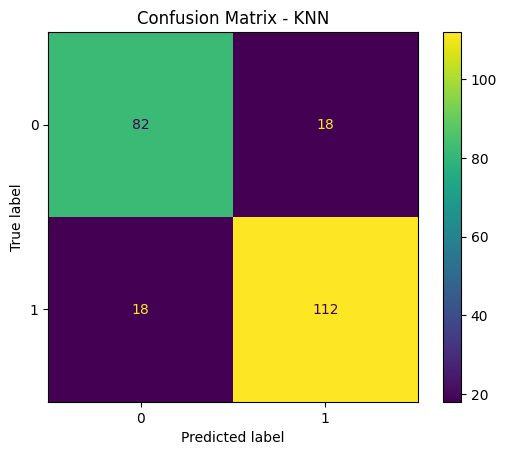

Confusion Matrix


<Figure size 640x480 with 0 Axes>

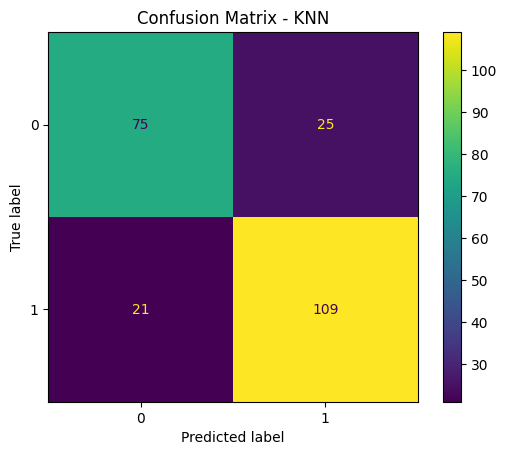

MODEL PERFORMANCE WITH BINARY CLASSIFICATION
Confusion Matrix


<Figure size 640x480 with 0 Axes>

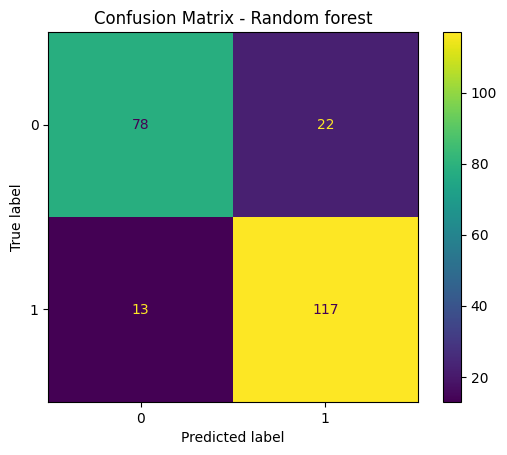

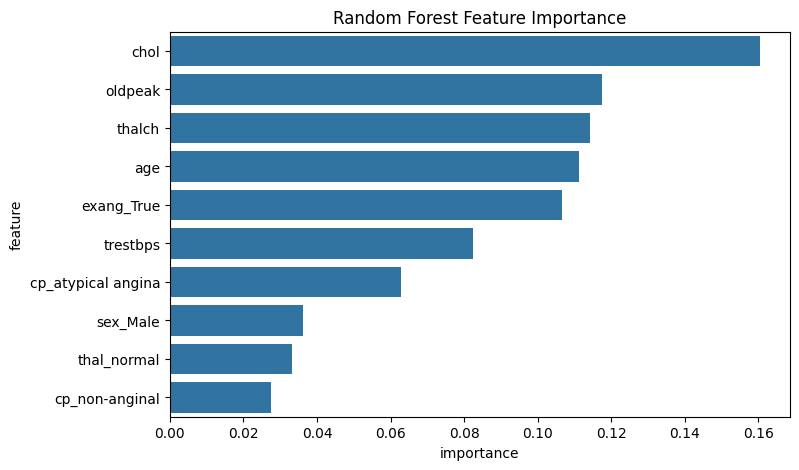

Confusion Matrix


<Figure size 640x480 with 0 Axes>

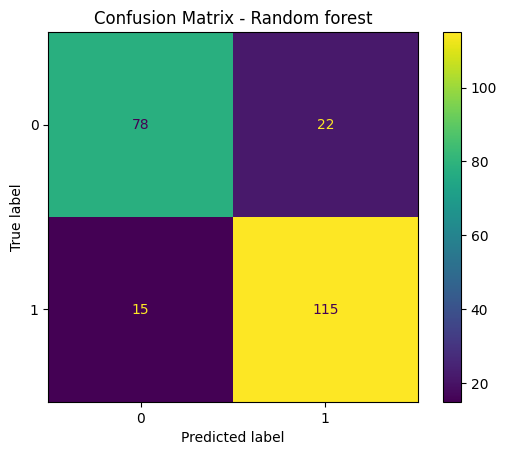

MODEL PERFORMANCE WITH BINARY CLASSIFICATION


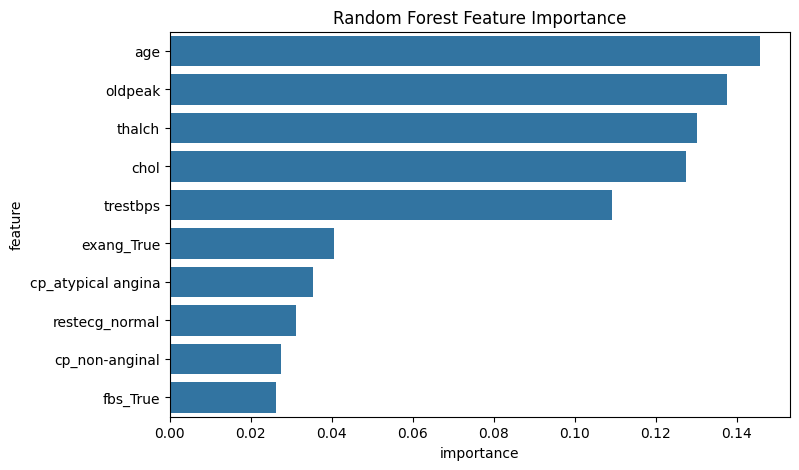

Confusion Matrix


<Figure size 640x480 with 0 Axes>

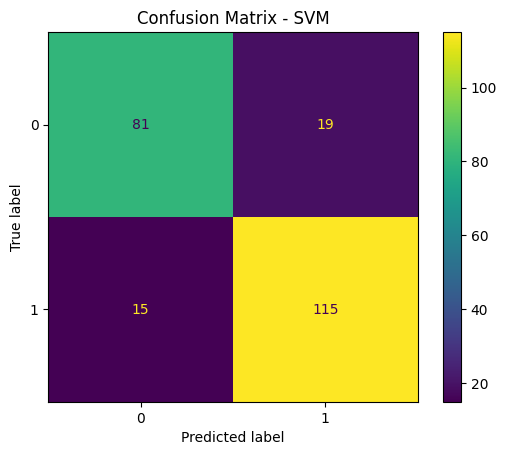

Confusion Matrix


<Figure size 640x480 with 0 Axes>

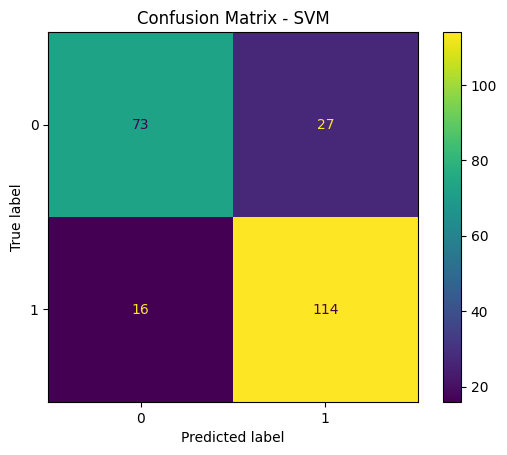

Confusion Matrix


<Figure size 640x480 with 0 Axes>

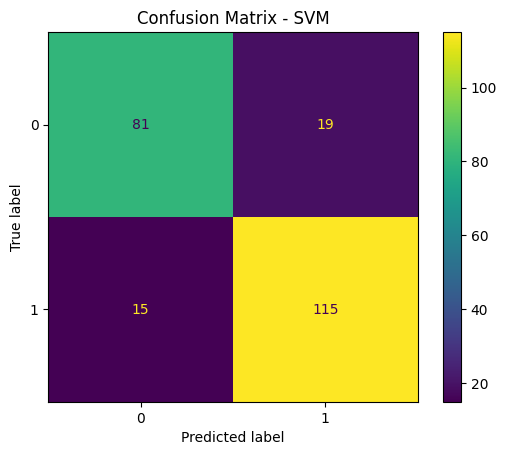

  Model  PCA F_Sel     Classes  Accuracy  Precision    Recall  F1-score
6   SVM   No    No      BINARY  0.852174   0.858209  0.884615  0.871212
8   SVM  Yes    No      BINARY  0.852174   0.858209  0.884615  0.871212
3    RF   No    No      BINARY  0.847826   0.841727  0.900000  0.869888
0   KNN   No    No      Binary  0.843478   0.861538  0.861538  0.861538
4    RF   No   Yes      BINARY  0.839130   0.839416  0.884615  0.861423
7   SVM   No   Yes      BINARY  0.813043   0.808511  0.876923  0.841328
1   KNN   No   Yes      Binary  0.800000   0.813433  0.838462  0.825758
5    RF   No    No  MULTICLASS  0.591304   0.575262  0.591304  0.561593
9   SVM   No    No  MULTICLASS  0.573913   0.499251  0.573913  0.506473
2   KNN   No    No  Multiclass  0.565217   0.476976  0.565217  0.505406


In [ ]:

results=[]

#Now the final comparison first binary and multiclass without feature selection

run_knn(X_train, y_train, X_val, y_val, X_test, y_test, k_values, False, True, False)
run_knn(X_train, y_train, X_val, y_val, X_test, y_test, k_values, True, True, False)
run_knn(X_Tr_5, y_Tr_5, X_Val_5, y_Val_5, X_Te_5, y_Te_5, k_values, False, False, False)

run_rf(X_train, y_train, X_test, y_test, False, True)
run_rf(X_train, y_train, X_test, y_test, True, True)
run_rf(X_Tr_5, y_Tr_5, X_Te_5, y_Te_5, False, False)

run_svm(X_train, y_train, X_test, y_test, False, True, False)
run_svm(X_train, y_train, X_test, y_test, True, True, False)
run_svm(X_train, y_train, X_test, y_test, False, True, True)
run_svm(X_Tr_5, y_Tr_5, X_Te_5, y_Te_5, False, False, False)

df_results = pd.DataFrame(results).sort_values(by='F1-score', ascending=False)
print(df_results)
